# Sea Ice Motion Correction
David Shean  
September 19, 2023

In [81]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

import rasterio as rio
from osgeo import gdal

In [82]:
from asp_plot_util import *

In [83]:
import numpy as np

#Compiled from pygeotools (dshean) and himat2cryo repositories

def checkma(a, fix=False):
    #isinstance(a, np.ma.MaskedArray)
    if np.ma.is_masked(a):
        out=a
    else:
        out=np.ma.array(a)
    return out

def maskfill(a, iterations=1, erode=False):
    import scipy.ndimage as ndimage 
    a = checkma(a)
    if erode:
        a = mask_islands(a, iterations)
    bmask = (~np.ma.getmaskarray(a))
    bmask_filled = ndimage.morphology.binary_fill_holes(bmask)
    #This will create valid values with a.filled in the original ma
    #a_erode.mask[:] = ~bmask_filled
    #return a_erode
    return ~bmask_filled

def gauss_fltr_astropy_fft(dem, size=None, sigma=None, origmask=True, fill_interior=False):
    
    """
    ***From pygeotools, commit to mainstream repo after full testing***
    # I use this over the direct Gaussian astropy filter  as it is way faster for large kernels
    Astropy gaussian filter properly handles convolution with NaN
    http://stackoverflow.com/questions/23832852/by-which-measures-should-i-set-the-size-of-my-gaussian-filter-in-matlab
    width1 = 3; sigma1 = (width1-1) / 6;
    Specify width for smallest feature of interest and determine sigma appropriately
    sigma is width of 1 std in pixels (not multiplier)
    scipy and astropy both use cutoff of 4*sigma on either side of kernel - 99.994%
    3*sigma on either side of kernel - 99.7%
    If sigma is specified, filter width will be a multiple of 8 times sigma 
    Alternatively, specify filter size, then compute sigma: sigma = (size - 1) / 8.
    If size is < the required width for 6-8 sigma, need to use different mode to create kernel
    mode 'oversample' and 'center' are essentially identical for sigma 1, but very different for sigma 0.3
    The sigma/size calculations below should work for non-integer sigma
    """

    #import astropy.nddata
    import astropy.convolution
    dem = checkma(dem)
    #Generate 2D gaussian kernel for input sigma and size
    #Default size is 8*sigma in x and y directions
    #kernel = astropy.nddata.make_kernel([size, size], sigma, 'gaussian')
    #Size must be odd
    if size is not None:
        size = int(np.floor(size/2)*2 + 1)
        size = max(size, 3)
    #Truncate the filter at this many standard deviations. Default is 4.0
    truncate = 3.0
    if size is not None and sigma is None:
        sigma = (size - 1) / (2*truncate)
    elif size is None and sigma is not None:
        #Round up to nearest odd int
        size = int(np.ceil((sigma * (2*truncate) + 1)/2)*2 - 1)
    elif size is None and sigma is None:
        #Use default parameters
        sigma = 1
        size = int(np.ceil((sigma * (2*truncate) + 1)/2)*2 - 1)
    size = max(size, 3)
    kernel = astropy.convolution.Gaussian2DKernel(sigma, x_size=size, y_size=size, mode='oversample')

    print("Applying gaussian smoothing filter with size %i and sigma %0.3f (sum %0.3f)" % \
            (size, sigma, kernel.array.sum()))

    #This will fill holes
    #np.nan is float
    #dem_filt_gauss = astropy.nddata.convolve(dem.astype(float).filled(np.nan), kernel, boundary='fill', fill_value=np.nan)
    #dem_filt_gauss = astropy.convolution.convolve(dem.astype(float).filled(np.nan), kernel, boundary='fill', fill_value=np.nan)
    #Added normalization to ensure filtered values are not brightened/darkened if kernelsum != 1
    dem_filt_gauss = astropy.convolution.convolve_fft(dem.astype(float).filled(np.nan), kernel, boundary='fill', 
                                                      fill_value=np.nan, normalize_kernel=True,
                                                     allow_huge=True)
    #This will preserve original ndv pixels, applying original mask after filtering
    if origmask:
        print("Applying original mask")
        #Allow filling of interior holes, but use original outer edge
        if fill_interior:
            mask = maskfill(dem)
        else:
            mask = np.ma.getmask(dem)
        dem_filt_gauss = np.ma.array(dem_filt_gauss, mask=mask, fill_value=dem.fill_value)
    out = np.ma.fix_invalid(dem_filt_gauss, copy=False, fill_value=dem.fill_value)
    out.set_fill_value(dem.fill_value.astype(dem.dtype))
    return out.astype(dem.dtype)

In [84]:
disp_fn = '/Users/dshean/scr/BlackSky/Utqiagvik_20220425_stereo/WV_comparison/22APR17225148-P1BS-506304172010_01_P001_ortho__BSG-102-20220425-215147-22900061_georeferenced-pan_ortho_rpc_vmap_maxm_35px_spm1/22APR17225148-P1BS-506304172010_01_P001_ortho__BSG-102-20220425-215147-22900061_georeferenced-pan_ortho_rpc_vmap_maxm_35px_spm1-F.tif'
disp_fn = '/Users/dshean/scr/utqiagvik/WV02_20220411_10300100D102A400_10300100D1B7D600/ncc_dgmaprpc/ncc_dgmaprpc-RD.tif'

In [85]:
disp_fn = '/Users/dshean/scr/utqiagvik/WV02_20220411_10300100D102A400_10300100D1B7D600/ncc_dgmaprpc/ncc_dgmaprpc-D_sub.tif'

In [86]:
#Reduce resolution for testing
#gdal_translate $gdal_opt -r cubic -outsize 12.5% 12.5% bm_crop-F.tif bm_crop-F_8x.tif
#Create copy, as we will modify this in place
#cp bm_crop-F.tif bm_crop-F_bu.tif
#disp_fn = '/Users/dshean/scr/utqiagvik/WV02_20220411_10300100D102A400_10300100D1B7D600/bm_crop/bm_crop-F_8x.tif'
disp_fn = '/Users/dshean/scr/utqiagvik/WV02_20220411_10300100D102A400_10300100D1B7D600/bm_crop/bm_crop-F_bu.tif'

In [87]:
#Specify output units
unit='pixels'
#unit='meters'
#Remove median offset in x and y
remove_bias = True
#Add quivers to offset magnitude plot to indicate direction
quiver = True

In [88]:
#Extract ground sample distance
with rio.open(disp_fn, mode='r+') as ds:
    gsd = ds.transform[0]
    crs = ds.crs
    gt = ds.transform

In [89]:
#Read band 1 (dx) and band 2 (dy) data
#TODO: load overview if present, prohibitively slow for large WV iamges
dx = read_array(disp_fn, 1)
dy = read_array(disp_fn, 2)

In [90]:
from pygeotools.lib import filtlib

In [91]:
#Remove median disparity
if remove_bias:
    dx_offset = np.ma.median(dx)
    dy_offset = np.ma.median(dy)
    print(dx_offset, dy_offset)
    dx -= dx_offset
    dy -= dy_offset

7.2852364 -1.4985685348510742


In [92]:
#Compute magnitude
#dm = np.sqrt(dx**2 + dy**2)

In [93]:
def plot_disp(dx, dy, dm=None, gsd=None, clim=None, units='pixels'):
    f, axa = plt.subplots(1, 3, figsize=(10, 3), dpi=220)

    #Scale offsets to meters
    if unit == 'meters':
        dx *= gsd
        dy *= gsd
    
    if dm is None:
        dm = np.sqrt(dx**2 + dy**2)

    #Compute robust colorbar limits (default is 2-98 percentile)
    if clim is None:
        clim = get_clim(dm, perc=(2,98), symm=True)
    print(clim)

    plot_ar(dx, axa[0], cmap='RdBu', clim=clim, label=unit) #f'x offset ({unit})'
    plot_ar(dy, axa[1], cmap='RdBu', clim=clim, label=unit)
    plot_ar(dm, axa[2], cmap='inferno', clim=(0, clim[1]), label=unit)
    
    #Add quiver vectors
    if quiver:
        #Set ~30 points for quivers along x dimension
        stride = int(dx.shape[1]/30.)
        iy, ix = np.indices(dx.shape)[:, ::stride, ::stride]
        dx_q = dx[::stride, ::stride]
        dy_q = dy[::stride, ::stride]
        #plt.quiver(ix, -iy, dx_q*gsd, dy_q*gsd)
        axa[2].quiver(ix, iy, dx_q, dy_q, color='white')
    
    #Add scalebar
    sb = ScaleBar(gsd)
    axa[0].add_artist(sb)
    axa[0].set_title('x offset')
    axa[1].set_title('y offset')
    axa[2].set_title('offset magnitude')
    
    plt.tight_layout()

(-48.483890533447266, 48.483890533447266)


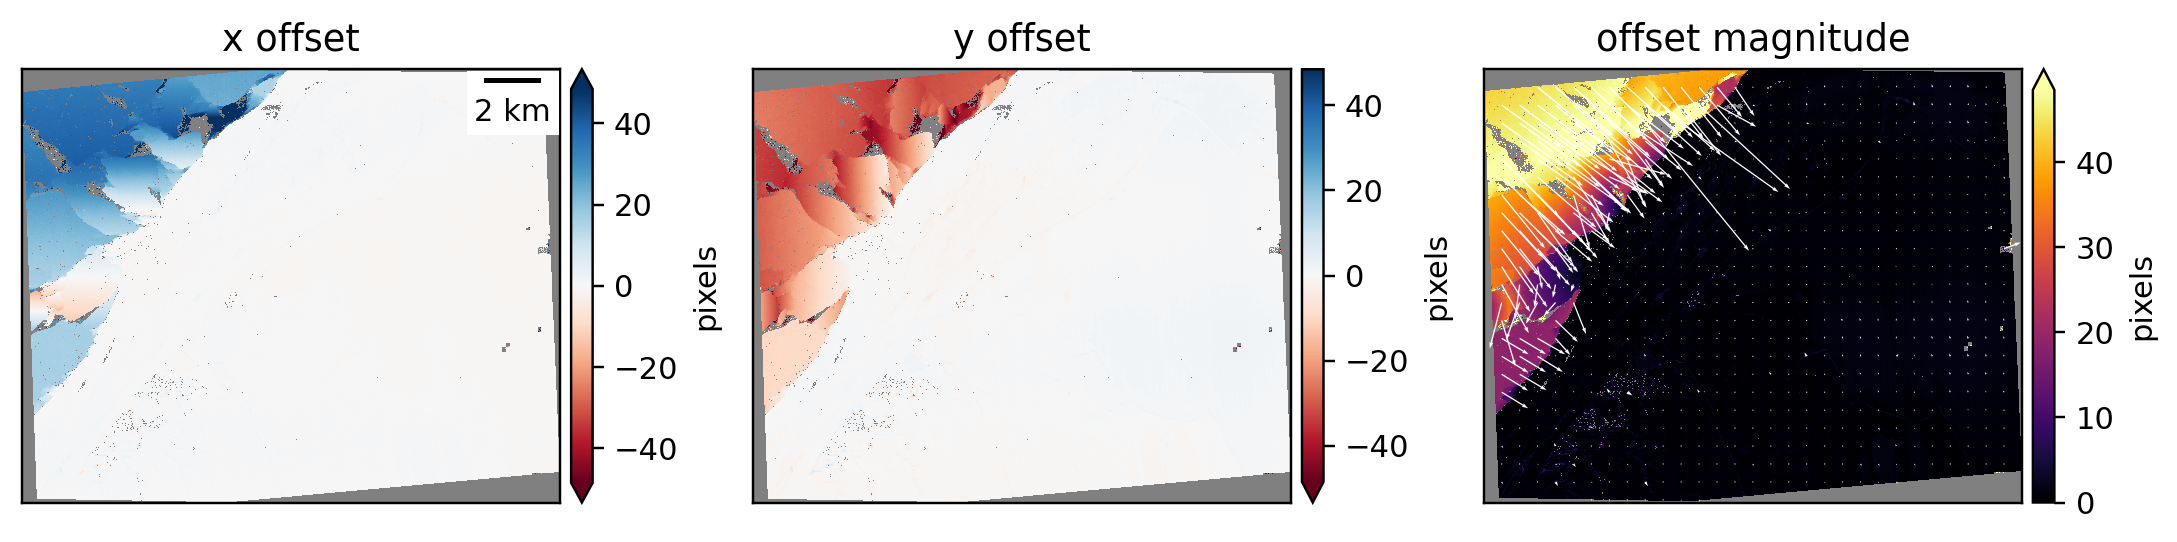

In [95]:
plot_disp(dx, dy, gsd=gsd)

## Prepare mask

In [96]:
import geopandas as gpd
from rasterio import features

In [97]:
mask_fn = '/Users/dshean/scr/utqiagvik/WV02_20220411_10300100D102A400_10300100D1B7D600/WV02_20220411_10300100D102A400_10300100D1B7D600_movingice_mask.geojson' 

In [98]:
mask_gdf = gpd.read_file(mask_fn)

In [99]:
mask_geom = mask_gdf.to_crs(crs).squeeze()

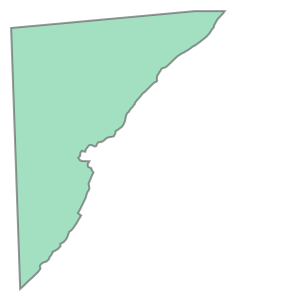

In [100]:
mask_geom

In [101]:
mask = features.rasterize((mask_geom, 1), out_shape=dx.shape, transform=gt).astype(bool)

/Users/dshean/sw/miniconda3/envs/shean_py3_amd/lib/python3.10/site-packages/rasterio/features.py:328: ShapeSkipWarning: Invalid or empty shape 1 at index 1 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


In [102]:
#Determine slice of the array for the filter (improves performance)
minrow, mincol = np.argwhere(mask).min(axis=0)
maxrow, maxcol = np.argwhere(mask).max(axis=0)

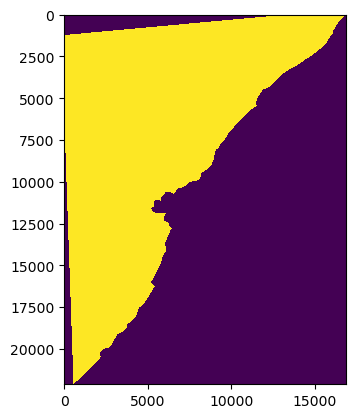

In [103]:
plt.imshow(mask[minrow:maxrow, mincol:maxcol]);

## High-pass filter

In [104]:
#Expected maximum feature width in meters
#Snow dunes correlation length is ~20 m (w/ anisotropy, 3:1, Glen Liston's model), amplitude ~10 cm std (perfectly flat, snow dunes, end member)
#Offshore ice - no snow dunes, ridges (~1 m high), ~25 m expansion of snow drifts (50 m wide), Limited snow in April 2022, 
max_feature_width = 80
kernel_width = np.ceil(max_feature_width/gsd) // 2 * 2 + 1 
sigma_width = int(np.round(kernel_width * 0.68))
#kernel_width = 9

In [105]:
print(kernel_width, sigma_width)

147.0 100


In [ ]:
dx_filt = dx[minrow:maxrow, mincol:maxcol] - gauss_fltr_astropy_fft(dx[minrow:maxrow, mincol:maxcol], size=kernel_width, sigma=sigma_width)

Applying gaussian smoothing filter with size 147 and sigma 100.000 (sum 1.000)


In [ ]:
dy_filt = dy[minrow:maxrow, mincol:maxcol] - gauss_fltr_astropy_fft(dy[minrow:maxrow, mincol:maxcol], size=kernel_width, sigma=sigma_width)

In [67]:
#dm_filt = np.sqrt(dx_filt**2 + dy_filt**2)

In [68]:
#plt.imshow(dx_filt, vmin=-1, vmax=1, cmap='RdBu')

(-2.4992265605926605, 2.4992265605926605)


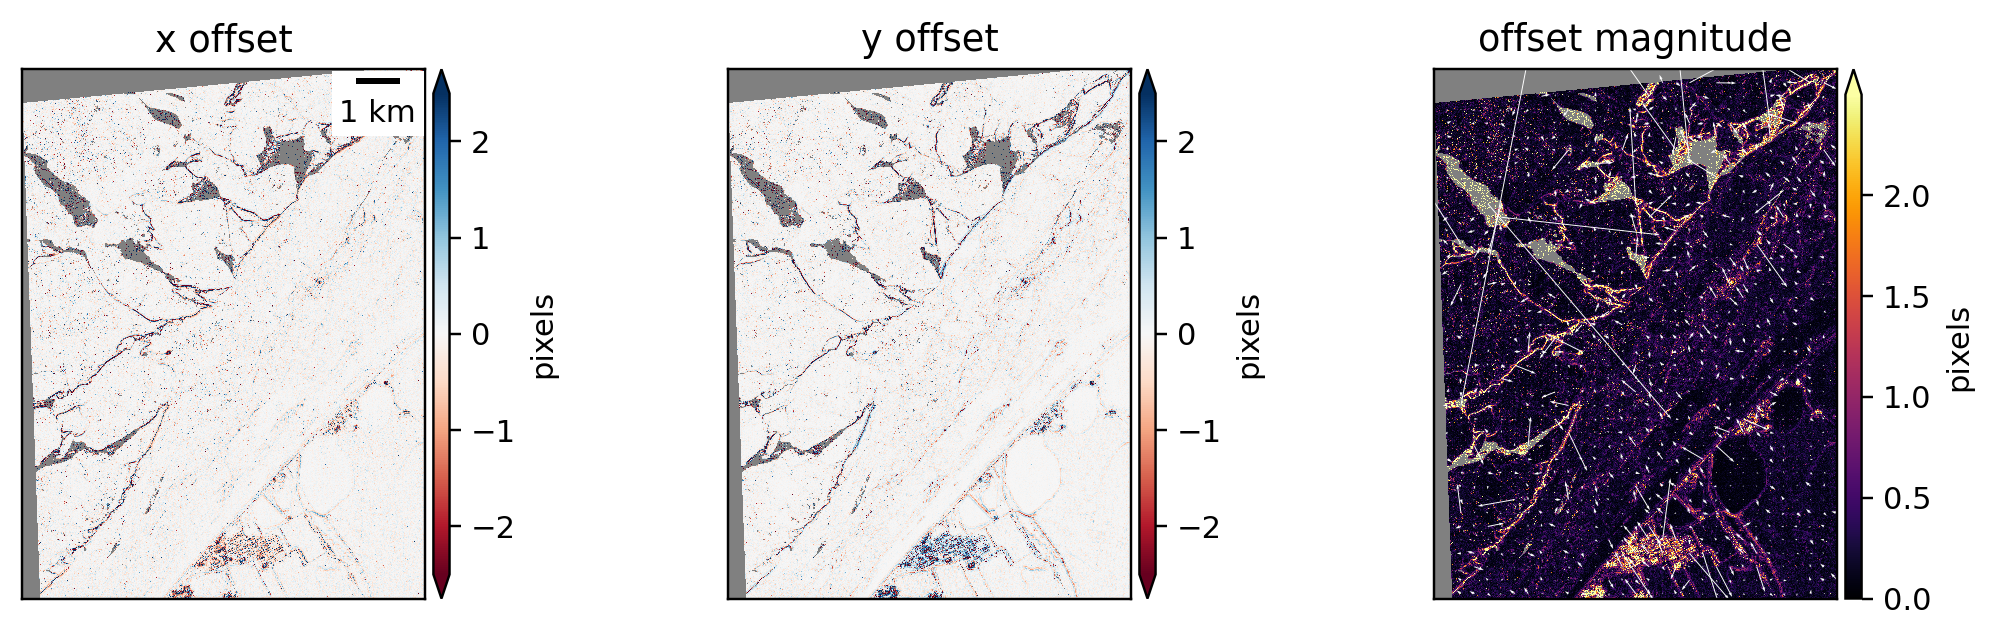

In [69]:
#plot_disp(dx_filt, dy_filt, gsd=gsd)

## Burn the filtered pixels into the original disparity maps

In [ ]:
#dx_filt[~mask] = dx[~mask]
#dy_filt[~mask] = dy[~mask]

In [ ]:
#This is cleaner, but a off by a few values, like clipping row/col
#dx[mask] = dx_filt[mask[minrow:maxrow, mincol:maxcol]]
#dy[mask] = dy_filt[mask[minrow:maxrow, mincol:maxcol]]

In [70]:
#Revisit this to get to bottom of issue with mask count off by a few pixels
dx[minrow:maxrow, mincol:maxcol][mask[minrow:maxrow, mincol:maxcol]] = dx_filt[mask[minrow:maxrow, mincol:maxcol]]
dy[minrow:maxrow, mincol:maxcol][mask[minrow:maxrow, mincol:maxcol]] = dy_filt[mask[minrow:maxrow, mincol:maxcol]]

(-2.1076107025146484, 2.1076107025146484)


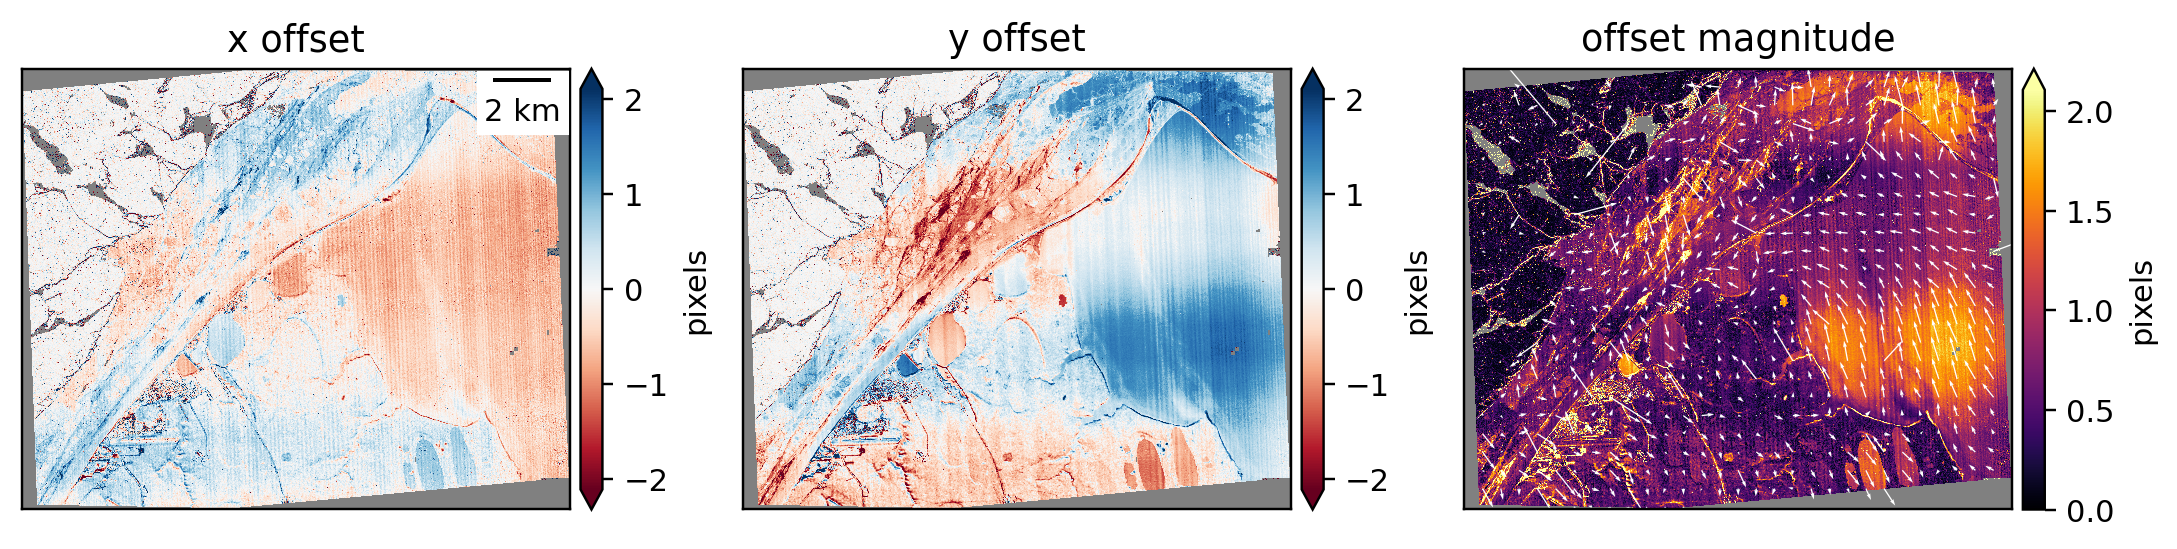

In [71]:
plot_disp(dx, dy, gsd=gsd)

In [72]:
disp_fn_out = '/Users/dshean/scr/utqiagvik/WV02_20220411_10300100D102A400_10300100D1B7D600/bm_crop/bm_crop-F_rewrite.tif'

In [73]:
#with rio.open(disp_fn_out, mode='r+') as ds:
#    ds.write(dx_filt+dx_offset, 1)
#    ds.write(dy_filt+dy_offset, 2)

In [74]:
with rio.open(disp_fn_out, mode='r+') as ds:
    ds.write(dx+dx_offset, 1)
    ds.write(dy+dy_offset, 2)